In [1]:
import gymnasium as gym
import numpy as np

class SeededFetchPickAndPlaceEnv(gym.Wrapper):
    def __init__(self, env, seed=None):
        super().__init__(env)
        self.seed = seed

    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=self.seed)
        return obs, info

    def seed(self, seed=None):
        self.np_random, seed = np.random.SeedSequence(seed)
        return [seed]

# Usage:
#env = gym.make('FetchPickAndPlace-v2')
#wrapped_env = SeededFetchPickAndPlaceEnv(env, 959)


In [2]:
def env_creator(env_config={}):
    import gymnasium as gym
    env = gym.make('FetchPickAndPlace-v2', render_mode='rgb_array', reward_type='dense', max_episode_steps=50)
    env = SeededFetchPickAndPlaceEnv(env, 960)
    env.reset()
    return env

In [3]:
from stable_baselines3 import HerReplayBuffer, DDPG, DQN, SAC, TD3
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.envs import BitFlippingEnv

model_class = SAC  # works also with SAC, DDPG and TD3
N_BITS = 15

env = env_creator({})#BitFlippingEnv(n_bits=N_BITS, continuous=model_class in [DDPG, SAC, TD3], max_steps=N_BITS)

# Available strategies (cf paper): future, final, episode
goal_selection_strategy = "future" # equivalent to GoalSelectionStrategy.FUTURE

# Initialize the model
model = model_class(
    "MultiInputPolicy",
    env,
    replay_buffer_class=HerReplayBuffer,
    # Parameters for HER
    replay_buffer_kwargs=dict(
        n_sampled_goal=4,
        goal_selection_strategy=goal_selection_strategy,
    ),
    verbose=1,
)

# Train the model
model.learn(500000)

model.save("./her_Fetch-PickAndPlace-Single-Task_Dense_env")
# Because it needs access to `env.compute_reward()`
# HER must be loaded with the env
model = model_class.load("./her_Fetch-PickAndPlace-Single-Task_Dense_env", env=env)

obs, info = env.reset()
for _ in range(100):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/lunet/cocp5/anaconda3/envs/R3L/lib/python3.9/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -18.8    |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 86       |
|    time_elapsed    | 2        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -5.86    |
|    critic_loss     | 0.109    |
|    ent_coef        | 0.971    |
|    ent_coef_loss   | -0.198   |
|    learning_rate   | 0.0003   |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -18.8    |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 69       |
|    time_elapsed    | 5        |
|    total_timesteps | 400      |
| train/             |          |
|    actor_los

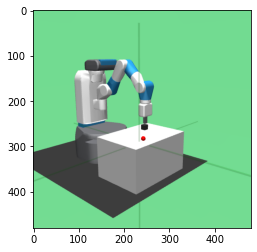

In [5]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
img = plt.imshow(env.render())

obs, info = env.reset()
for _ in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()
    img.set_data(env.render()) # Just update the data
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)